# Demo VirtualHome

This is a demo of how to run VirtualHome UnitySimulator. The demo will walk though how to start an environment and visualize it, how to prepare it to perform activities and finally how to perform activities in them.

In [1]:
%matplotlib notebook
import IPython.display
from utils_demo import *
from sys import platform
import sys
from PIL import Image
import matplotlib.pyplot as plt

sys.path.append('../simulation')
from unity_simulator.comm_unity import UnityCommunication
from unity_simulator import utils_viz

import os


# Starting communication

The first step is to start a communication with the simulator. Make sure before you run this that you have downloaded the simulator, and placed it under the `simulation` folder. You will be interacting with the simulator with the communication `comm` created here. You can include the file name of the simulator or just call `UnityCommunication()` and manually open the executable.

In [2]:
mode = 'manual' # auto / manual
if mode == 'auto':
    if platform == 'darwin':
        exec_file = '../simulation/macos_exec'
    else:
        exec_file = '../simulation/unity_simulator/linux_exec/linux_exec.v2.2.4.x86_64'
    comm = UnityCommunication(file_name=exec_file)
else:
    comm = UnityCommunication()

# Starting and Visualizing Scenes

After initalizing the simulation. We can interact with the environments provided in VirtualHome. The simulator is composed of 7 apartments, which can be seen here.

In [3]:
img = get_img_apts()
IPython.display.display(img)

NameError: name 'get_img_apts' is not defined

## Scene start and display

We will start scene number 4 and start visualizing it. We start it by calling reset. Scenes are numbered from 0 to 6.

In [4]:
comm.reset(4)

False

In [5]:
s, im = comm.camera_image([0])

Each scene has multiple cameras, we will take screenshots for some of the cameras in this scene, specified by indices.

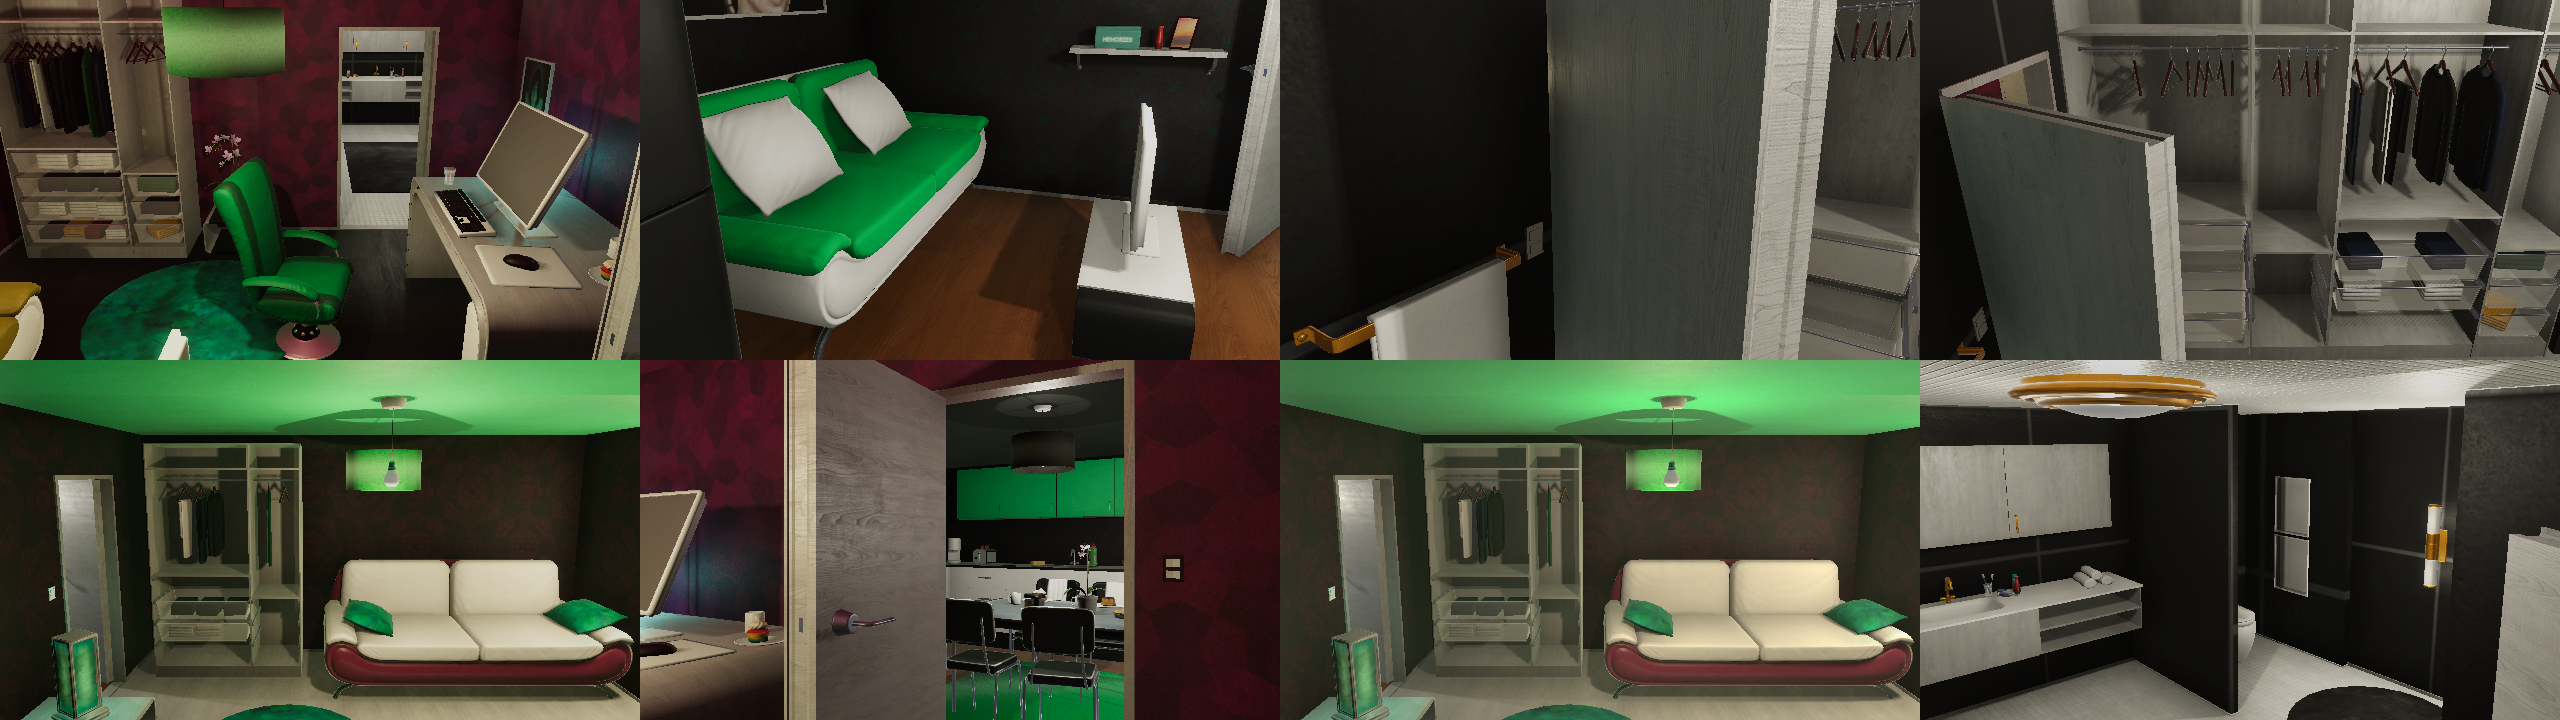

In [6]:
indices = [3, 32, -5, -1, -20, 15, 48, -8]
img_final = display_scene_cameras(comm, indices, nrows=2)
IPython.display.display(img_final)

## VirtualHome supports multiple modalities

The cameras can also display other modalities, such as semantic segmentation, depth, instance segmentation or optical flow when playing videos. We will display a few of those here.

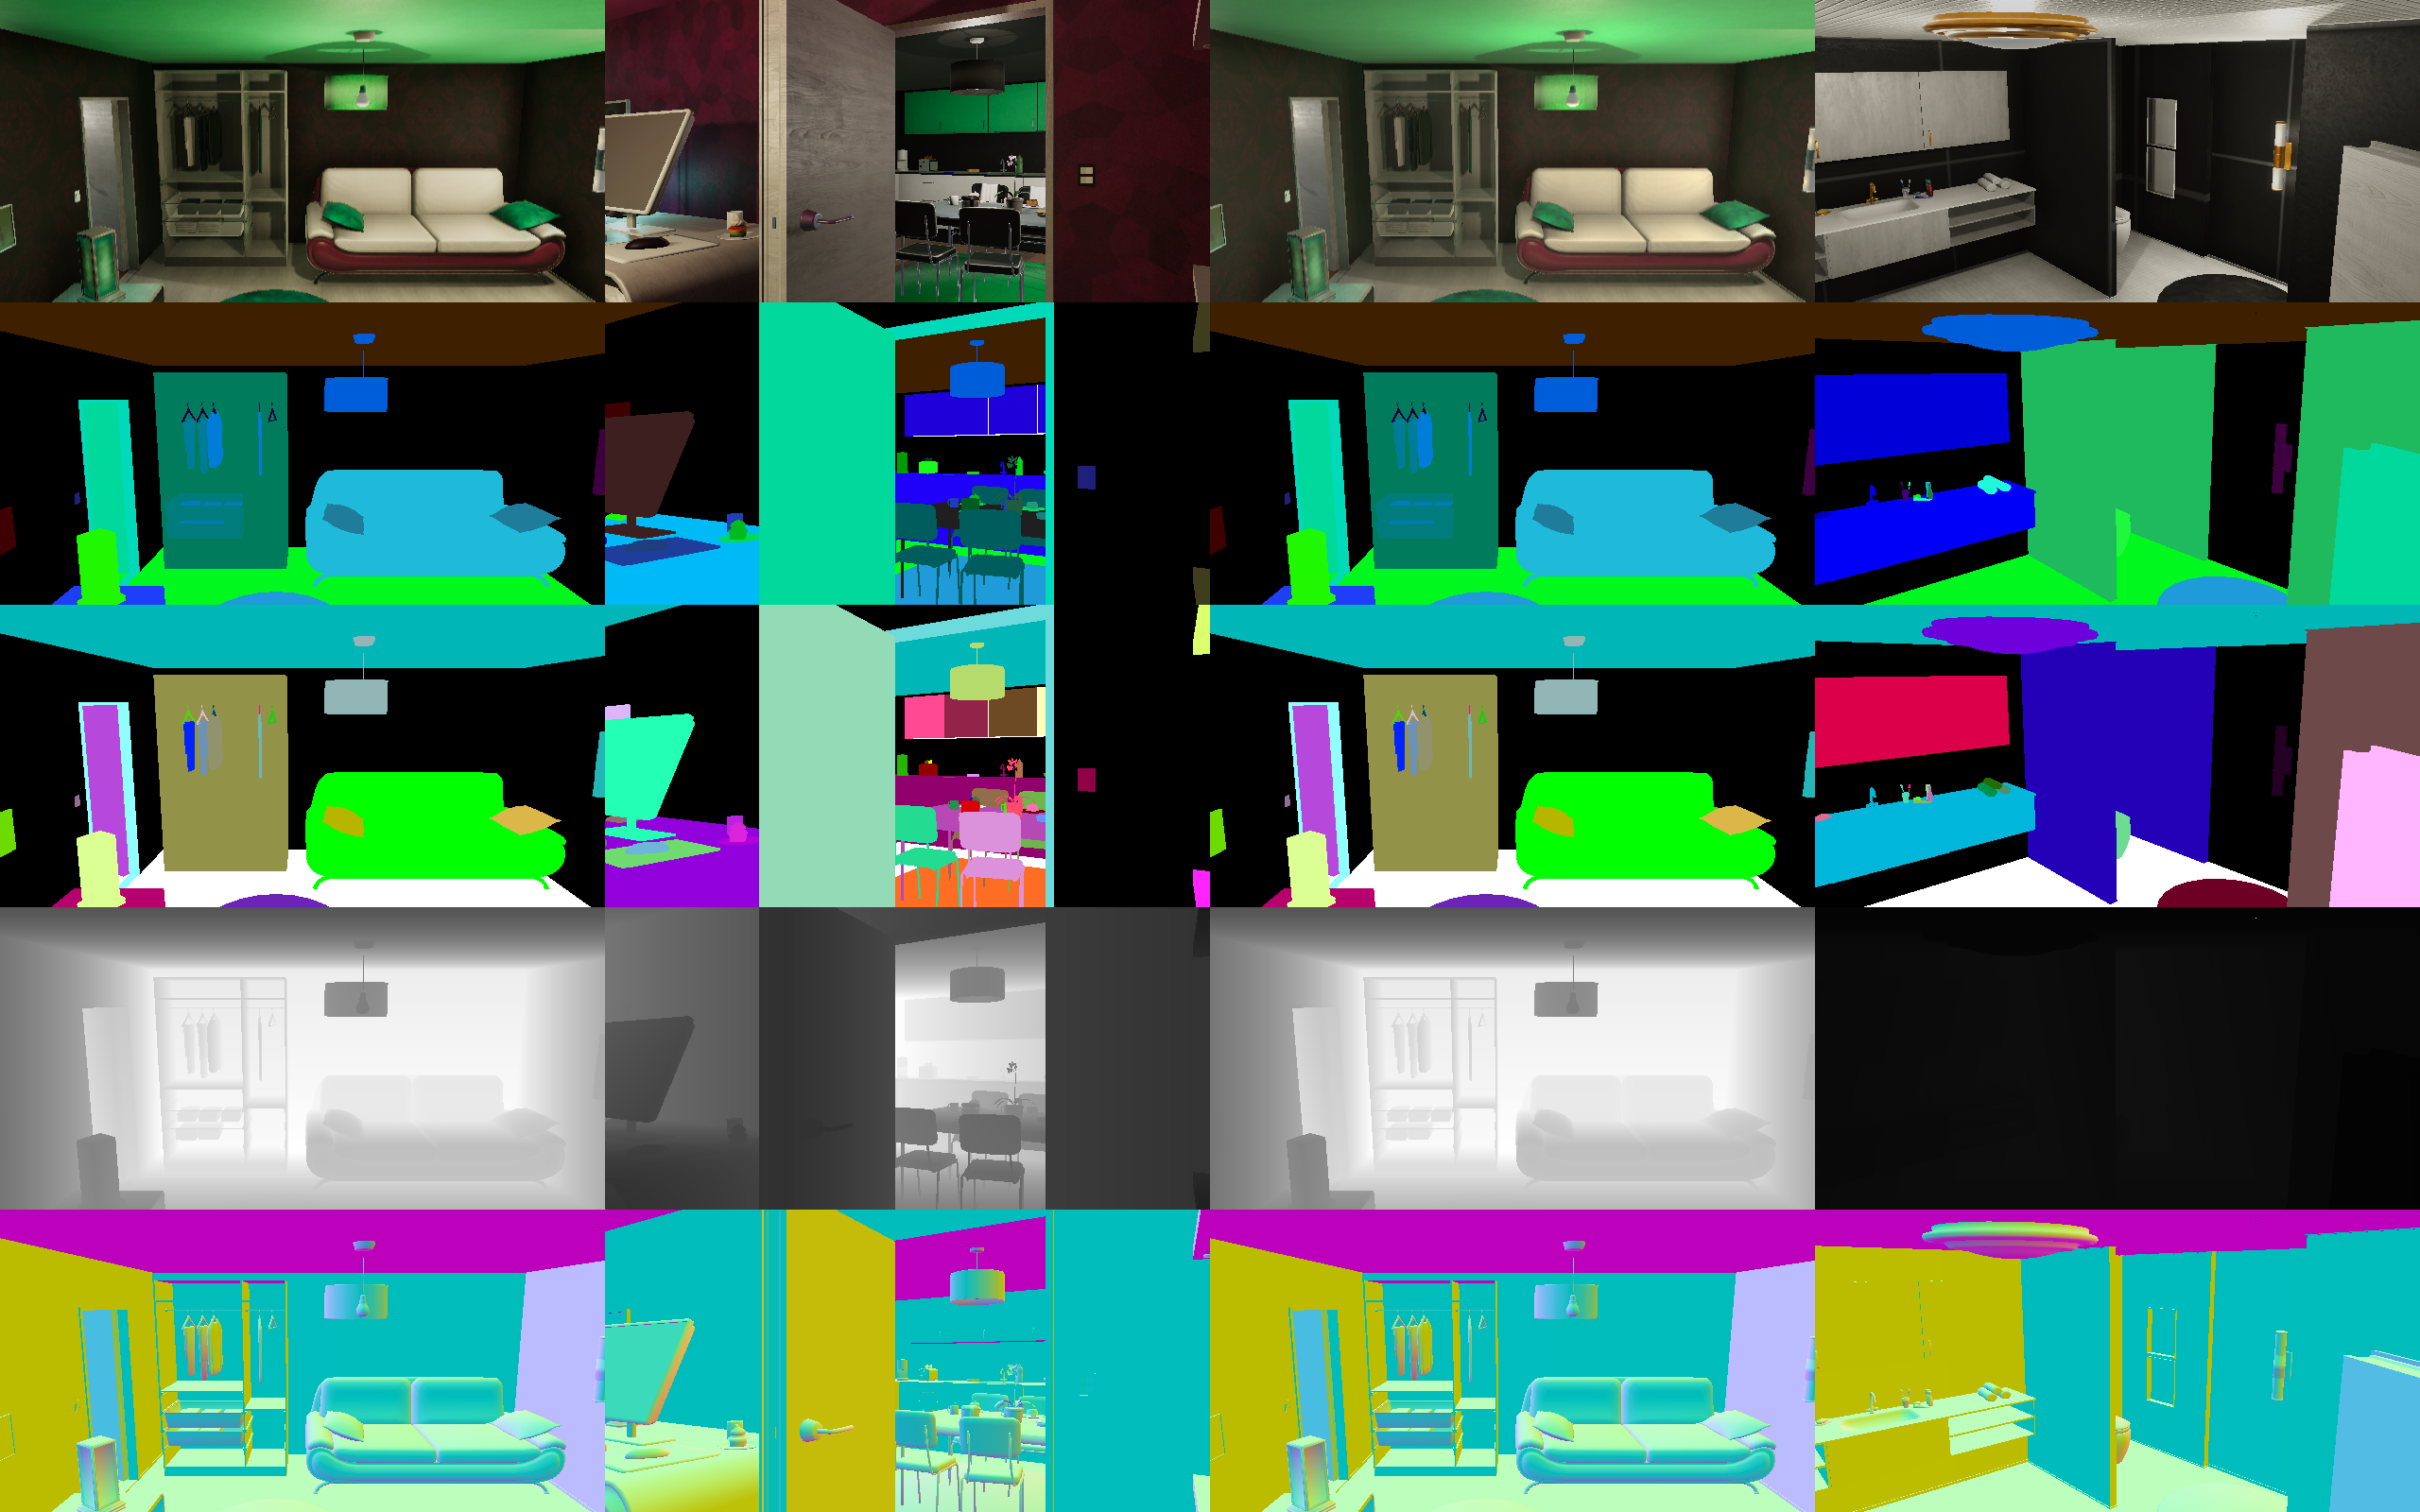

In [7]:
indices = [-20, 15, 48, -8]
img_final = display_scene_modalities(
    comm, 
    indices, 
    modalities=['normal', 'seg_class', 'seg_inst', 'depth', 'surf_normals'], nrows=5)
IPython.display.display(img_final)

## Including cameras

You can also add new cameras in the scene and get screenshots from those

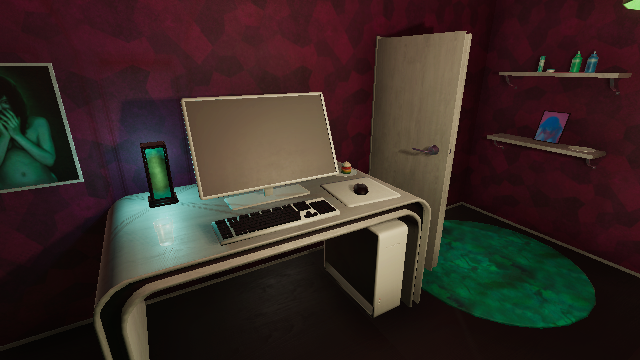

In [8]:
# specify the position and rotation of the camera
comm.add_camera(position=[0,1.8,0], rotation=[20, 120, 0])

# Get the last camera
s, c = comm.camera_count()
img_final = display_scene_cameras(comm, [c-1], nrows=1)
IPython.display.display(img_final)

## Visualizing the scene as a graph

Each scene in VirtualHome can be visualized as a graph, allowing to query the objects appearing, and their relationships. We start by obtaining the graph from the current scene.

In [9]:
comm.reset(4)
s, graph = comm.environment_graph()

The graph is a dictionary with `nodes` and `edges`. Each node corresponds to an object and contains information such as.
- class_name: the object_name
- states: in which state the object is
- id: a number you can use to perform actions over the object 

Let's print one of the nodes, to see more of the information

In [10]:
graph['nodes'][140]

{'id': 151,
 'category': 'Appliances',
 'class_name': 'stovefan',
 'prefab_name': 'PRE_APP_Stove_fan_01',
 'obj_transform': {'position': [3.106, 0.104, 0.759],
  'rotation': [0.0, 0.7071068, 0.0, 0.7071067],
  'scale': [1.0, 1.0, 1.0]},
 'bounding_box': {'center': [3.105993, 2.18690538, 0.9091453],
  'size': [0.9244467, 0.450402617, 0.621286452]},
 'properties': [],
 'states': []}

The edges connect object ids with spatial relationships, such as `INSIDE`, `ON`, `CLOSE`. You can check more of them in the `simulation` folder.

In [11]:
graph['edges'][:5]

[{'from_id': 12, 'to_id': 11, 'relation_type': 'INSIDE'},
 {'from_id': 13, 'to_id': 11, 'relation_type': 'INSIDE'},
 {'from_id': 14, 'to_id': 11, 'relation_type': 'INSIDE'},
 {'from_id': 15, 'to_id': 11, 'relation_type': 'INSIDE'},
 {'from_id': 16, 'to_id': 11, 'relation_type': 'INSIDE'}]

The graph also contains bounding box and center information, which may be useful to reason about the environment layout.

# Modifying your environment and preparing for activities

In the previous section we viewed how to read and visualize the environment. Now we are interested in modifying the environment to perform activities in them. 

## Get default environment

All the environments have a default setting. We can go to this setting by calling reset()

In [12]:
comm.reset(4)

False

## Adding Objects

We will start by adding objects to interact with in the environments. We can start by adding a cat in the environment.

### Adding a cat

We first want to make sure that the cat will be added in the current environment. Let's say that we want to add it in one of the sofas.

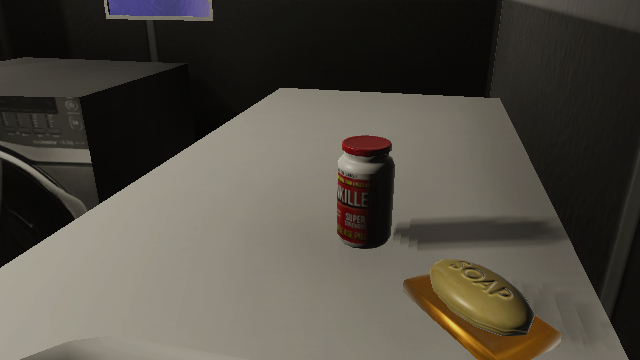

In [13]:
imgs_prev = get_scene_cameras(comm, [-4])
display_grid_img(imgs_prev, nrows=1)

We start by reading the graph and looking for one of the sodas in the scene.

In [14]:
success, graph = comm.environment_graph()
sofa = find_nodes(graph, class_name='sofa')[-2]
print(sofa)

{'id': 139, 'category': 'Furniture', 'class_name': 'sofa', 'prefab_name': 'PRE_FUR_Sofa_02_03_02_01', 'obj_transform': {'position': [6.888, 0.051, -4.879], 'rotation': [0.0, 1.0, 0.0, 3.57627869e-07], 'scale': [0.911715746, 0.911715746, 0.911715746]}, 'bounding_box': {'center': [6.89529371, 0.5715897, -4.879], 'size': [0.9469976, 0.885002553, 2.155935]}, 'properties': ['SURFACES', 'SITTABLE', 'LIEABLE', 'MOVABLE'], 'states': []}


We now add one node with id `1000` of type cat, and an edge between the sofa node and the cat, specifying that the cat should be on the sofa.

In [15]:
add_node(graph, {'class_name': 'cat', 
                   'category': 'Animals', 
                   'id': 1000, 
                   'properties': [], 
                   'states': []})
add_edge(graph, 1000, 'ON', sofa['id'])

In [16]:
syrup = find_nodes(graph, class_name='chocolatesyrup')[0]
print(syrup)

{'id': 206, 'category': 'Foods', 'class_name': 'chocolatesyrup', 'prefab_name': 'SMGP_PRE_Chocolate_syrup_1024', 'obj_transform': {'position': [4.568927, 1.07107389, 0.8001744], 'rotation': [0.0, 0.2979861, 0.0, 0.9545703], 'scale': [0.242501974, 0.242501974, 0.242501974]}, 'bounding_box': {'center': [4.568927, 1.17176378, 0.8001741], 'size': [0.11949186, 0.202268228, 0.1308295]}, 'properties': ['GRABBABLE', 'EATABLE', 'CUTTABLE', 'MOVABLE'], 'states': []}


#### Update environment

The graph is now updated, but now we have to call the simulator so that the environment gets updated with the graph. Let's do it.

In [17]:
success, message = comm.expand_scene(graph)

You can now take an image of the environment, you will see how there has been a cat added in the environment

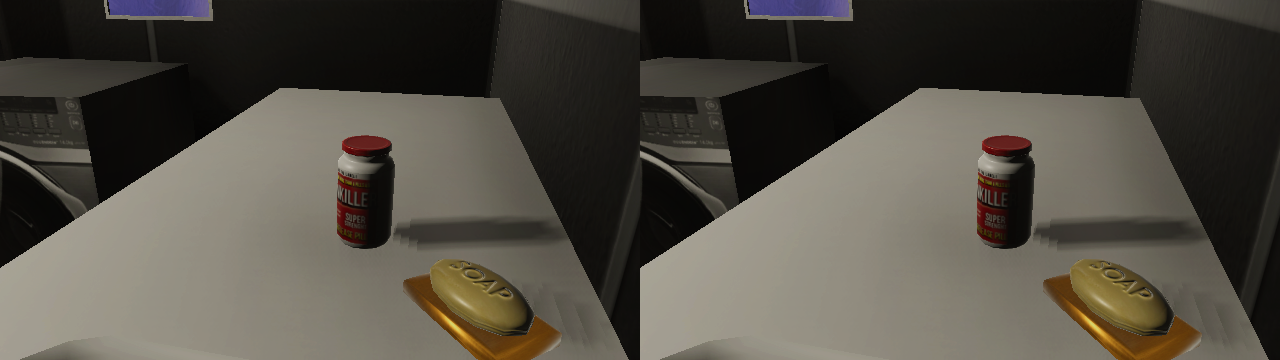

In [18]:
imgs_final = get_scene_cameras(comm, [-4])
display_grid_img(imgs_prev+imgs_final, nrows=1)

In [19]:
imgs_prev = imgs_final

### Opening fridge

We may not want to add any new object, but just to change the state of the current objects. We can do this very similarly, by changing the environment graph. Let's say we want to open the fridge.

We read again the graph

In [20]:
success, graph = comm.environment_graph();

We find the node `fridge` and change its `states` to open. 

In [21]:
fridge = find_nodes(graph, class_name='fridge')[0]

In [22]:
fridge['states'] = ['CLOSE']

We finally expand the graph, as we did before.

In [23]:
success = comm.expand_scene(graph)

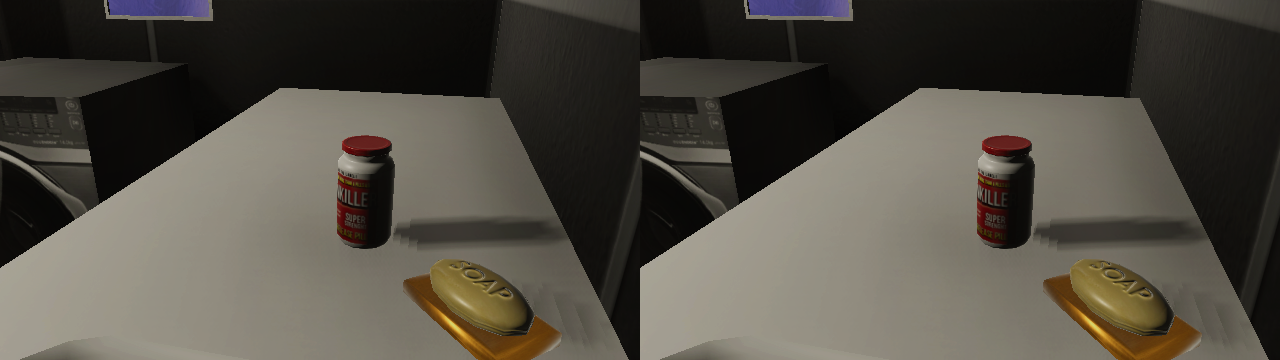

In [24]:
imgs_final = get_scene_cameras(comm, [-4])
display_grid_img(imgs_prev+imgs_final, nrows=1)

### Applicances

We will use the same method as before to change the state of some appliances. Again just by modifying the state of the graph.

We take a picture of the apartment to see how it looks before doing any change

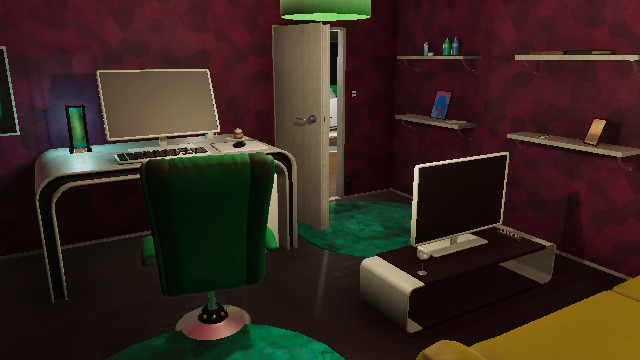

In [25]:
#SKipped
# indices = [0]
# imgs_prev = get_scene_cameras(comm, indices)
# display_grid_img(imgs_prev, nrows=1)

We now get the graph of the environment, and select a TV and a light

In [26]:
success, graph = comm.environment_graph()
prev_graph = graph
tv_node = [x for x in graph['nodes'] if x['class_name'] == 'tv'][0]
light_node = [x for x in graph['nodes'] if x['class_name'] == 'lightswitch'][0]

We change the state and modify the scene with the new graph.

In [27]:
#skipped
# tv_node['states'] = ['OFF']
# light_node['states'] = ['ON']
# _ = comm.expand_scene(graph)
# last_graph = graph

We visualize the final scene

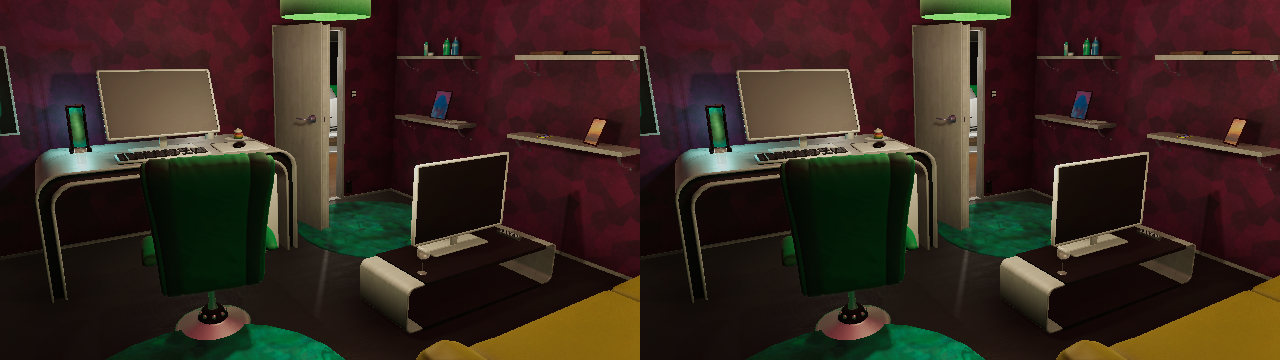

In [29]:
#skipped
# imgs_final = get_scene_cameras(comm, indices)
# display_grid_img(imgs_prev+imgs_final, nrows=1)


# Generating Scripts

We now can start scenes, visualize them and modify them. The last step is to perform activities in them. We do this by defining scripts: Lists of instructions that will be executed in sequence. Each instruction contains an action, an object, and an id. The id should match with the `id` of each of the nodes in the environment graph.

You can check the list of actions currently implemented [here](https://github.com/xavierpuigf/virtualhome/tree/master/simulation#actions)

### Adding a character

The first step is to add agents in the environment, that will be performing the activity. You can specify which agent you want to add and the room where you want to add it

In [27]:
comm.reset(4)
tv_node['states'] = ['OFF']
comm.expand_scene(prev_graph)
comm.add_character('chars/Female2', initial_room='kitchen')
s, g = comm.environment_graph()
cat_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'cat'][0]
sofa_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'sofa'][0]
microwave_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'microwave'][0]
plate_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'plate'][0]
light_node = [x for x in graph['nodes'] if x['class_name'] == 'lightswitch'][0]
tv_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'tv'][0]
bed_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'bed'][0]
radio_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'radio'][0]
fridge_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'fridge'][0]
towel_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'towel'][0]
counter_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'kitchencounter'][0]

If you count the number of cameras, you will see that a few new cameras have been added into the scene. These are cameras attached to the character. When the character moves, the cameras will move as well.

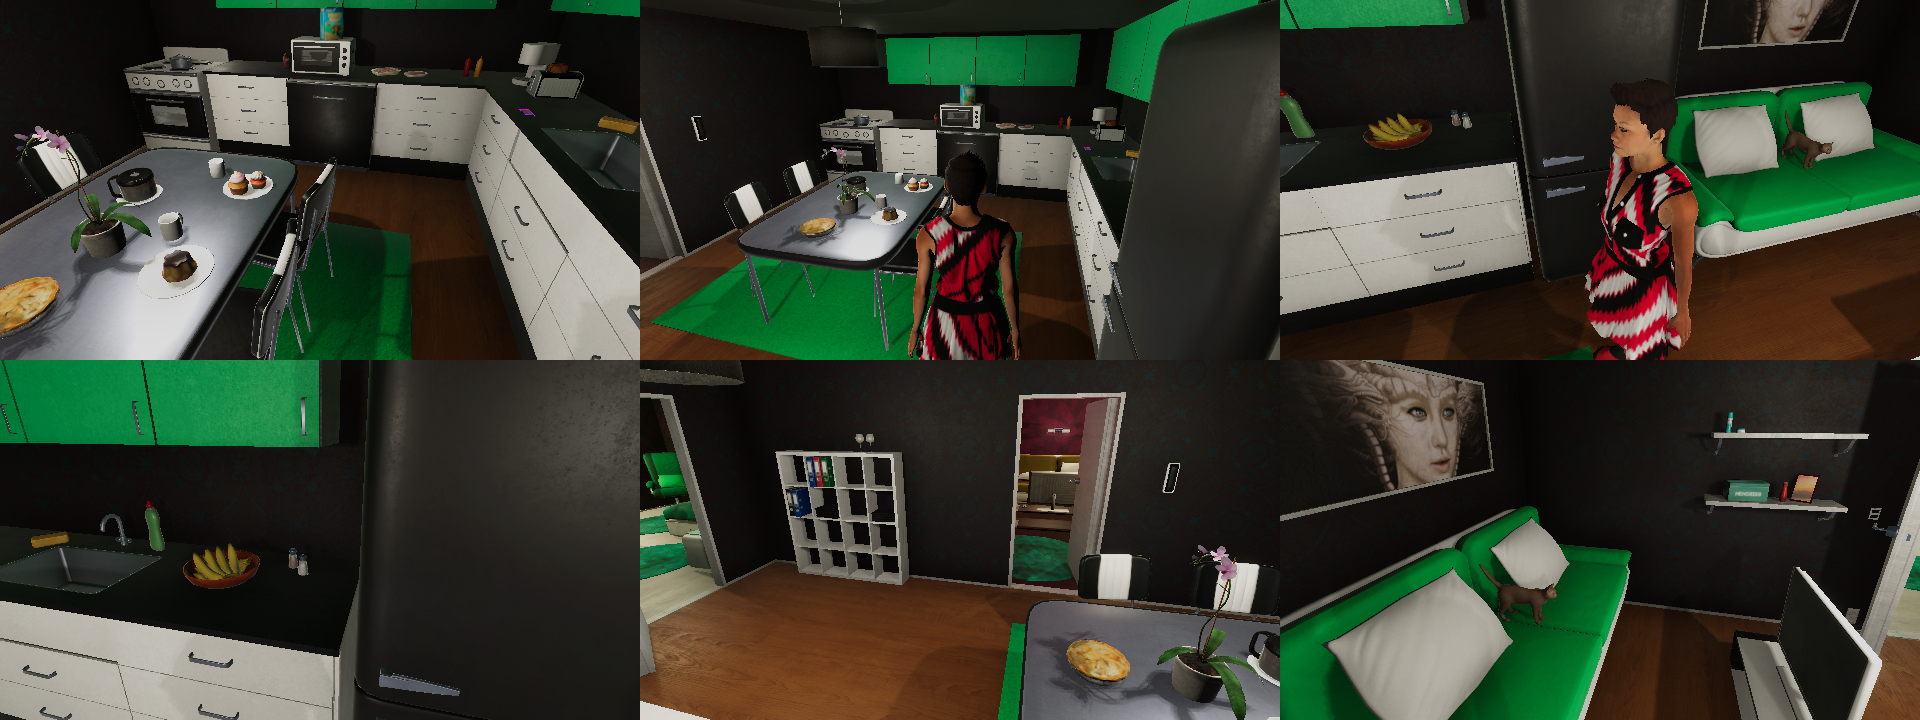

In [28]:
s, nc = comm.camera_count()
indices = range(nc - 6, nc)
imgs_prev = get_scene_cameras(comm, indices)
display_grid_img(imgs_prev, nrows=2)

## Generating the first script

Let's start by interacting witht the cat and the sofa that we set up before. The cat had id 1000. The sofa was stored in a variable `sofa` containing that node. We can query its id directly. This sequence will make the agent walk to the sofa, grab the cat and sit in the sofa.

In [29]:
script = ['<char0> [Find] <fridge> ({})'.format(fridge_id),
          '<char0> [Find] <plate> ({})'.format(plate_id),
          '<char0> [Grab] <plate> ({})'.format(plate_id),
          '<char0> [Find] <microwave> ({})'.format(microwave_id), 
          '<char0> [Open] <microwave> ({})'.format(microwave_id),
          '<char0> [PutIn] <plate> ({}) <microwave> ({})'.format(plate_id, microwave_id),
          '<char0> [SwitchOn] <microwave> ({})'.format(microwave_id),
          '<char0> [SwitchOn] <lightswitch> ({})'.format(light_node['id']),
          '<char0> [Walk] <tv> ({})'.format(tv_id),
          '<char0> [SwitchOn] <tv> ({})'.format(tv_id),
          '<char0> [Walk] <bed> ({})'.format(bed_id),
          '<char0> [Sit] <bed> ({})'.format(bed_id),
          '<char0> [SwitchOn] <radio> ({})'.format(radio_id),
          '<char0> [Sit] <bed> ({})'.format(bed_id),
          '<char0> [StandUp] <bed> ({})'.format(bed_id),
          '<char0> [Find] <towel> ({})'.format(towel_id),
          '<char0> [Find] <kitchencounter> ({})'.format(counter_id),
          '<char0> [Find] <cat> ({})'.format(cat_id),
          '<char0> [Grab] <cat> ({})'.format(cat_id),
          '<char0> [Sit] <sofa> ({})'.format(sofa['id'])]

#           '<char0> [Find] <fridge> ({})'.format(fridge_id),
#           '<char0> [Open] <fridge> ({})'.format(fridge_id),
#           '<char0> [Close] <fridge> ({})'.format(fridge_id),
#           '<char0> [Find] <towel> ({})'.format(towel_id),
#           '<char0> [Grab] <towel> ({})'.format(towel_id),
#           '<char0> [Find] <kitchencounter> ({})'.format(counter_id),
#           '<char0> [Find] <cat> ({})'.format(cat_id),
#           '<char0> [Grab] <cat> ({})'.format(cat_id),
#           '<char0> [Sit] <sofa> ({})'.format(sofa['id'])]

         
#           '<char0> [Walk] <tv> (1)',
#           '<char0> [switchon] <tv> (1)',
#           '<char0> [Walk] <sofa> (1)',
#           '<char0> [Sit] <sofa> (1)',
#           '<char0> [Watch] <tv> (1)', 

# script = ['<char0> [Walk] <sofa> ({})'.format(sofa['id']),
#           '<char0> [Find] <cat> ({})'.format(cat_id),
#           '<char0> [Grab] <cat> ({})'.format(cat_id),
#           '<char0> [Sit] <sofa> ({})'.format(sofa['id'])]


In [30]:
comm.add_sensor(position=[1.5,0,-2.67000008], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[0.270000011,0,-2.5], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[-1.44000006,0,-2.71000004], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[1.5,0,-1.5], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[-1.5,0,-1.5], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[1.25999999,0,-0.5], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[0,0,-0.5], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[-1.5,0,-0.5], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[6,0,-2.31999993], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[5.5999999,0,-3.5], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[3.29999995,0,-2.31999993], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[6,0,-1.31999993], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[3.29999995,0,-1.31999993], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[6,0,-0.319999933], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[4.80000019,0,-0.319999933], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[3.5999999,0,-0.319999933], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[4.5999999,0,-3.5], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[3.5,0,-3.5], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[3.5,0,-4.69999981], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[2.5999999,0,-10.3900003], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[1.35000002,0,-9.23999977], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[1.36000001,0,-10.3100004], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[3.63000011,0,-7.97000027], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[2.57999992,0,-9.25], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[3.63000011,0,-6.97000027], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[2.63000011,0,-7.98999977], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[3.74000001,0,-9.76000023], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[4.03000021,0,4.51999998], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[2.59000015,0,4.51999998], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[1.38999987,0,4.51999998], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[2.59000015,0,2.6099999], 
                rotation=[0,0,0], 
                radius=1)
comm.add_sensor(position=[1.38999987,0,2.6099999], 
                rotation=[0,0,0], 
                radius=1)

(True, 'New sensor created. Id:31')

In [30]:
# comm.add_sensor(position=[7.34600019,2.09299994,-5.85099983], 
#                 rotation=[0,180,0], 
#                 radius=5)
# comm.add_sensor(position=[6.95800018,1.42999995,-2.59299994], 
#                 rotation=[0,270,0], 
#                 radius=5)
# comm.add_sensor(position=[3.24300003,1.84500003,-11.1639996], 
#                 rotation=[0,270,0], 
#                 radius=5)
# comm.add_sensor(position=[-2.41499996,1.84500003,-1.18299997], 
#                 rotation=[0,0,0], 
#                 radius=5)
# comm.add_sensor(position=[3.33800006,1.94599998,2.35500002], 
#                 rotation=[0,180,0], 
#                 radius=5)

(True, 'New sensor created. Id:4')

We now want to execute the script in the environment. We do that through render_script. Notice that we can specify a file name, which will be used to save a video with the activity.

In [31]:
success, message = comm.render_script(script=script,
                                      processing_time_limit=60,
                                      find_solution=True,
                                      image_width=512,
                                      image_height=320,  
                                      skip_animation=False,
                                      recording=True,
                                      save_pose_data=True,
                                      file_name_prefix='relax',
                                      camera_mode=['PERSON_FROM_BACK'])



UnityCommunicationException: HTTPConnectionPool(host='127.0.0.1', port=8085): Read timed out. (read timeout=30)

This saves the frames of the video into the `Output/relax` folder, which should be where you had your executable. Let's generate a video from the frames.

In [37]:
# Enter here the path to the video, it should be in the same location where you stored your executable 
path_video = "../../../../virtualhome_unity/Output/"
utils_viz.generate_video(input_path=path_video, prefix='relax', output_path='.')

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [33]:
display_vid('./video_normal.mp4')

FileNotFoundError: [Errno 2] No such file or directory: './video_normal.mp4'

Other paramters to render_script are:
- script: a list of script lines
- randomize_execution: randomly choose elements
- random_seed: random seed to use when randomizing execution, -1 means that the seed is not set
- find_solution: find solution (True) or use graph ids to determine object instances (False)
- processing_time_limit: time limit for finding a solution
- skip_execution: skip rendering, only check if a solution exists
- output_folder: folder to output renderings, default is Output/
- file_name_prefix: prefix of created files (screenshots are put to output_folder/file_name_prefix/)
- frame_rate: frame rate
- capture_screenshot: save screenshots
- image_synthesis: save depth, segmentation, flow images
- save_pose_data: save pose data
- save_scene_states: save scene states
- character_resource: path to character resource to be used
- camera_mode: automatic (AUTO), first person (FIRST_PERSON), top (PERSON_TOP), front person view (PERSON_FRONT)

In [34]:
# We can also visualize the skeleton

path_video = "../simulation/unity_simulator/linux_exec/Output/"
pose_char, frames = utils_viz.get_skeleton(input_path=path_video, prefix='relax')
ax = plt.axes(projection='3d')
frame = 40
center_char = pose_char.mean(1)
ax.scatter3D(pose_char[frame, :, 0], pose_char[frame, :, 2], pose_char[frame, :, 1])
ax.set_xlim(center_char[frame, 0]-0.8, center_char[frame, 0] + 0.8)
ax.set_ylim(center_char[frame, 2]-0.8, center_char[frame, 2] + 0.8)

FileNotFoundError: [Errno 2] No such file or directory: '../simulation/unity_simulator/linux_exec/Output//relax/0//pd_relax.txt'

## Generating a script without a video

In some occasions you may not be interested in generating a full video for the script, for example if you want to do RL. You can run the script withtout rendering a video by setting image_synthesis to empty. This will execute the script much more quickly

Restart the previous graph

In [37]:
comm.reset()
comm.expand_scene(prev_graph)
comm.add_character()
s, g = comm.environment_graph()

Run with `image_synthesis=[]`

In [38]:
success, message = comm.render_script(script=script,
                                      processing_time_limit=60,
                                      find_solution=False,
                                      image_synthesis=[])

In [39]:
script

['<char0> [Walk] <sofa> (139)',
 '<char0> [Find] <cat> (366)',
 '<char0> [Grab] <cat> (366)',
 '<char0> [Sit] <sofa> (139)']

## Generating from multiple views

We can chose which camera to use while rendering the videos. This is done through the flag `CAMERA_MODE`.

In [40]:
comm.reset(4)
_, _ = comm.expand_scene(last_graph)
comm.add_character()
success, message = comm.render_script(script=script,
                                      processing_time_limit=60,
                                      find_solution=False,
                                      recording=True,
                                      image_synthesis=['normal'],
                                      camera_mode=['FIRST_PERSON'])

In [41]:
message

{'0': {'message': 'Success'}}

## Generating underspecified videos

If we do not care which objects the simulator should interact with, we can also let it decide. If we use the flag `find_solution=True` we can start enumerating objects by `1` instead of following the graph ids. Unity will try to find a solution. Note that if we want to interact with 2 objects of the same kind, they will need to have different ids (i.e. 1 and 2)

In [69]:
comm.reset(6)

True

In [70]:
s, g = comm.environment_graph()
[node for node in g['nodes'] if node['class_name'] == 'milk']

[{'id': 195,
  'category': 'Food',
  'class_name': 'milk',
  'prefab_name': 'FMGP_PRE_Milk_1024',
  'obj_transform': {'position': [-6.0326767, 0.982, 2.08764076],
   'rotation': [0.0, 0.0, 0.0, 1.0],
   'scale': [1.0, 1.0, 1.0]},
  'bounding_box': {'center': [-6.0326767, 1.102379, 2.08764029],
   'size': [0.123023987, 0.240758, 0.123024985]},
  'properties': ['GRABBABLE', 'DRINKABLE', 'POURABLE', 'CAN_OPEN', 'MOVABLE'],
  'states': ['CLOSED']}]

In [71]:
comm.add_character()

True

In [72]:
script = ['<char0> [walk] <milk> (1)',
          '<char0> [grab] <milk> (1)',
          '<char0> [walk] <microwave> (1)',
          '<char0> [open] <microwave> (1)',
          '<char0> [putin] <milk> (1) <microwave> (1)',
          '<char0> [close] <microwave> (1)',
          '<char0> [switchon] <microwave> (1)']
          
success, message = comm.render_script(script=script, 
                                      find_solution=True,
                                      processing_time_limit=80,
                                      frame_rate=15,
                                      image_width=512, image_height=320,
                                      skip_animation=False,
                                      image_synthesis=['normal'],
                                      camera_mode=['PERSON_FROM_BACK'],
                                      recording=True,
                                      file_name_prefix='milk')

# Multi-agent Actions

You can also generate actions with multiple agents in them, simply add more agents, and specify which agents should do which action

In [ ]:
# Reset the scene
comm.reset(0)
s, g = comm.environment_graph()
# Add two agents this time
comm.add_character('Chars/Male2', initial_room='kitchen')
comm.add_character('Chars/Female4', initial_room='bedroom')

# Get nodes for salmon and microwave, glass, faucet and sink
salmon_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'salmon'][0]
microwave_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'microwave'][0]
glass_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'waterglass'][-1]
sink_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'sink'][0]
faucet_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'faucet'][-1]


# Put salmon in microwave
script = [
    '<char0> [walk] <salmon> ({}) | <char1> [walk] <glass> ({})'.format(salmon_id, glass_id),
    '<char0> [grab] <salmon> ({}) | <char1> [grab] <glass> ({})'.format(salmon_id, glass_id),
    '<char0> [open] <microwave> ({}) | <char1> [walk] <sink> ({})'.format(microwave_id, sink_id),
    '<char0> [putin] <salmon> ({}) <microwave> ({}) | <char1> [putback] <glass> ({}) <sink> ({})'.format(salmon_id, microwave_id, glass_id, sink_id),
    '<char0> [close] <microwave> ({}) | <char1> [switchon] <faucet> ({})'.format(microwave_id, faucet_id)
]
comm.render_script(script, frame_rate=10, camera_mode=["PERSON_FROM_BACK"])

# Interactive agents


So far we have seen how to generate videos, but we can use the same command to deploy or train agents in the environment. You can execute the previous instructions one by one, and get an observation or graph at every step. or that, you don't need to generate videos or have animations, since it will slow down your agents. Use `skip_animation=True` to generate actions without animating them. Remember to turn off the recording mode as well.

In [73]:
# Reset the scene
comm.reset(0)

# Add two agents this time
comm.add_character('Chars/Male2', initial_room='kitchen')
comm.add_character('Chars/Female4', initial_room='bedroom')

# Get nodes for salmon and microwave, glass, faucet and sink
salmon_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'salmon'][0]
microwave_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'microwave'][0]
glass_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'waterglass'][-1]
sink_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'sink'][0]
faucet_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'faucet'][-1]


# Put salmon in microwave
script = [
    '<char0> [walk] <salmon> ({}) | <char1> [walk] <glass> ({})'.format(salmon_id, glass_id),
    '<char0> [grab] <salmon> ({}) | <char1> [grab] <glass> ({})'.format(salmon_id, glass_id),
    '<char0> [open] <microwave> ({}) | <char1> [walk] <sink> ({})'.format(microwave_id, sink_id),
    '<char0> [putin] <salmon> ({}) <microwave> ({}) | <char1> [putback] <glass> ({}) <sink> ({})'.format(salmon_id, microwave_id, glass_id, sink_id),
    '<char0> [close] <microwave> ({}) | <char1> [switchon] <faucet> ({})'.format(microwave_id, faucet_id)
]

s, cc = comm.camera_count()
for script_instruction in script:
    print(script_instruction)
    comm.render_script([script_instruction], recording=False, skip_animation=True)
    # Here you can get an observation, for instance
    s, im = comm.camera_image([cc-3], image_width=300, image_height=300)

IndexError: list index out of range

# Record agent pose

Use the following commands to record pose and videos

In [ ]:
comm.reset(6)

In [ ]:
s, g = comm.environment_graph()
[node for node in g['nodes'] if node['class_name'] == 'milk']

In [ ]:
comm.add_character()

In [ ]:
script = ['<char0> [walk] <milk> (1)',
          '<char0> [grab] <milk> (1)',
          '<char0> [walk] <microwave> (1)',
          '<char0> [open] <microwave> (1)',
          '<char0> [putin] <milk> (1) <microwave> (1)',
          '<char0> [close] <microwave> (1)',
          '<char0> [switchon] <microwave> (1)']          

In [ ]:
comm.start_recording(script=script,
                     find_solution=True,
                     processing_time_limit=80,
                     frame_rate=15,
                     image_width=512, image_height=320,
                     skip_animation=False,
                     image_synthesis=['normal'],
                     camera_mode=['PERSON_FROM_BACK'],
                     recording=True,
                     file_name_prefix='milk')

In [ ]:
comm.stop_recording()

# Add sensor

Use the following commands to add a sensor in the environment and to update the sensor position or values

In [12]:
comm.add_sensor(position=[7.34600019,2.39299994,-5.85099983], 
                rotation=[0,0,0], 
                field_view=5)

(True, 'New sensor created. Id:0')